# 0 Imports

In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
import torch

# 1 Dataset and Dataloader

In [42]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
from pathlib import Path

class ImageCaptionDataset(Dataset):
    def __init__(self, image_folder, captions_file, processor):

        self.image_folder = image_folder
        self.processor = processor

        root_img, root_cpt = Path(image_folder), Path(captions_file)
        if not (root_img.exists() and root_img.is_dir()):
            raise ValueError(f"Data root '{root_img}' is invalid")
        
        if not (root_cpt.exists() and root_cpt.is_file()):
            raise ValueError(f"Data root '{root_cpt}' is invalid")

        self.df = pd.read_table(captions_file, sep=",", header=None, names=["image", "caption"], dtype='str')
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        img_name = os.path.join(self.image_folder, self.df.iloc[idx, 0])
        image = Image.open(img_name)
        caption = self.df.iloc[idx, 1]
        
        encoding = self.processor(images=image, text=caption, padding="max_length", return_tensors="pt").to(device)
        encoding = {k: v.squeeze() for k,v in encoding.items()}

        return encoding, image

In [44]:
IMG_SIZE = 224

processor = AutoProcessor.from_pretrained("microsoft/git-base")
# train_dataset = ImageCaptionDataset("../data/val_small", "../data/val_small/small_captions_val.txt", processor)
train_dataset = ImageCaptionDataset("../data/train", "../data/train/captions_train.txt", processor)
test_dataset = ImageCaptionDataset("../data/test", "../data/test/captions_test.txt", processor)

# item = train_dataset[0]
# for k,v in item.items():
	# print(k,v.shape)

In [4]:
BATCH_SIZE = 2

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)

batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)
processor.decode(batch["input_ids"][0])

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


'[CLS] a brown dog catching a ball in silhouette. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

# 2 Model definition

In [5]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base").to(device)

cpu


# 2.1 initial loss

In [6]:
outputs = model(
    input_ids=batch["input_ids"],
	attention_mask=batch["attention_mask"],
	pixel_values=batch["pixel_values"],
	labels=batch["input_ids"]
)
outputs.loss

/home/white/miniconda3/envs/dml/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


tensor(12.1147, device='cuda:0', grad_fn=<NllLossBackward0>)

# 3 Training 

In [7]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
# num_epoch = 3

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

# model.train()

# train_loss = []
# for epoch in range(num_epoch):
# 	for idx, batch in enumerate(train_dataloader):
# 		torch.cuda.empty_cache()
# 		input_ids = batch.pop("input_ids").to(device)
# 		pixel_values = batch.pop("pixel_values").to(device)
# 		attention_mask = batch.pop("attention_mask").to(device)

# 		outputs = model(input_ids=input_ids, pixel_values=pixel_values,labels=input_ids, attention_mask=attention_mask)
		
# 		loss = outputs.loss
# 		if (idx+1) % 10 == 0: 
# 			print(f"Epoch [{epoch+1}/{num_epoch}] - step [{idx+1}/{len(train_dataloader)}] - Loss: {loss.item():.4f}")
# 			train_loss.append(loss.item())

# 		loss.backward()

# 		optimizer.step()
# 		optimizer.zero_grad()

Epoch [1/3] - step [10/1113] - Loss: 8.5455
Epoch [1/3] - step [20/1113] - Loss: 7.4808
Epoch [1/3] - step [30/1113] - Loss: 6.4121
Epoch [1/3] - step [40/1113] - Loss: 5.3208
Epoch [1/3] - step [50/1113] - Loss: 4.1953
Epoch [1/3] - step [60/1113] - Loss: 3.0810
Epoch [1/3] - step [70/1113] - Loss: 2.0347
Epoch [1/3] - step [80/1113] - Loss: 1.2197
Epoch [1/3] - step [90/1113] - Loss: 0.6279
Epoch [1/3] - step [100/1113] - Loss: 0.3697
Epoch [1/3] - step [110/1113] - Loss: 0.3429
Epoch [1/3] - step [120/1113] - Loss: 0.2926
Epoch [1/3] - step [130/1113] - Loss: 0.2470
Epoch [1/3] - step [140/1113] - Loss: 0.1536
Epoch [1/3] - step [150/1113] - Loss: 0.1965
Epoch [1/3] - step [160/1113] - Loss: 0.1428
Epoch [1/3] - step [170/1113] - Loss: 0.0991
Epoch [1/3] - step [180/1113] - Loss: 0.1678
Epoch [1/3] - step [190/1113] - Loss: 0.1219
Epoch [1/3] - step [200/1113] - Loss: 0.1187
Epoch [1/3] - step [210/1113] - Loss: 0.0900
Epoch [1/3] - step [220/1113] - Loss: 0.1206
Epoch [1/3] - step 

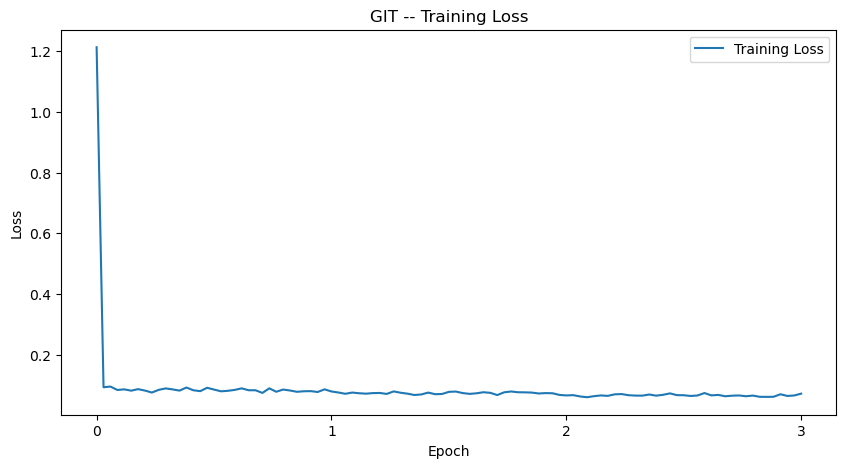

In [25]:
import matplotlib.pyplot as plt

def mean(l): return sum(l)/len(l)

lt = len(train_loss)
step = 100
t_l = [mean(train_loss[i:min(i+lt//step, lt)]) for i in range(0, lt, lt//step)]
plt.figure(figsize=(10,5))
plt.plot(t_l, label='Training Loss')
plt.title('GIT -- Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(ticks=range(0, len(t_l), len(t_l)//3), labels=range(0, 4))
plt.legend()
plt.show()
# plt.savefig('../img/GIT.pdf', format='pdf')

# 4 Caption generation

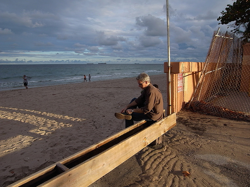

a man sits on a bench near the beach, tying his shoe.


In [52]:
import random

idx = random.randint(0, len(test_dataset)) 
df = pd.read_table("../data/test/captions_test.txt", sep=",", header=None, names=["image", "caption"], dtype='str')
img_name = os.path.join("../data/test", df.iloc[idx, 0])
image = Image.open(img_name)
width, height = image.size
display(image.resize((int(0.5*width), int(0.5*height))))

def generate_caption(idx, model, processor):
    encoding, image = test_dataset[idx]

    # Make sure encoding is moved to the right device
    encoding = {k: v.unsqueeze(0).to(device) for k, v in encoding.items() if k in ['input_ids', 'pixel_values']}
    
    # Generate caption
    with torch.no_grad():
        generated_ids = model.generate(**encoding, max_length=513)
    
    # Decode generated caption
    generated_caption = processor.decode(generated_ids[0], skip_special_tokens=True)

    return generated_caption

caption = generate_caption(idx, model, processor)
print(caption)

# 5 Checkpoint

In [45]:
# save model
# torch.save(
    # {
        # "model_state_dict": model.state_dict(),
        # "train_losses": train_loss,
    # },
    # "ckpt/git.ckpt",
# )

ckpt = torch.load("../ckpt/git.ckpt", map_location="cpu")

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")
model.load_state_dict(ckpt["model_state_dict"])

train_loss = ckpt["train_losses"]

/tmp/ipykernel_23084/3951400815.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("../ckpt/git.ckpt", map_location="cpu")
